In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
from tqdm import tqdm

# Measuring various quantities of interest

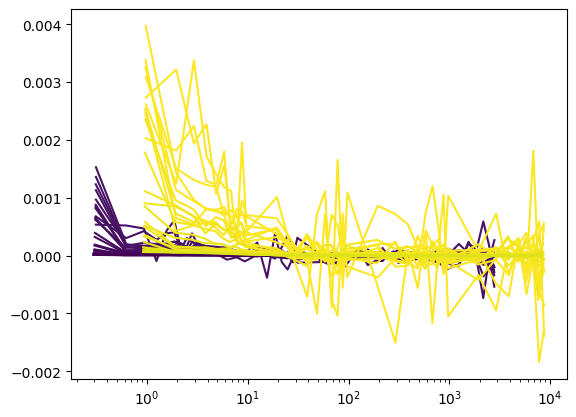

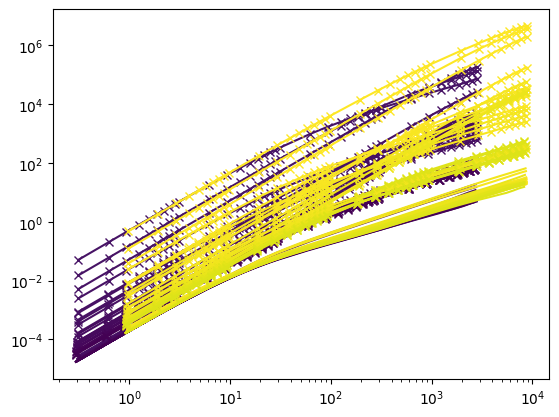

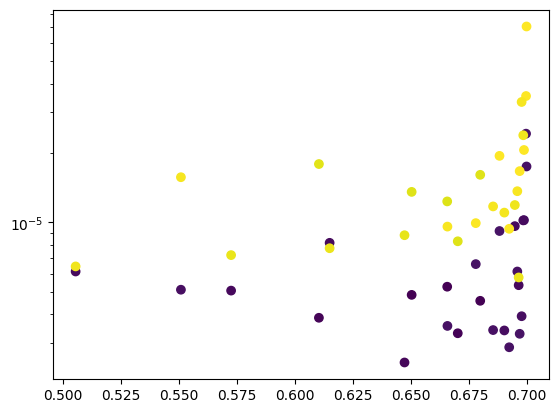

In [24]:
root = '/home/mmccraw/dev/data/09-27-25/test-scales'
# disk, rigid

root = os.path.join(root, 'rigid')
is_rigid = 'rigid' in root
T = []
M = []
G = []
TIME = []
TE = []
PHI = []
MU = []

for temperature in os.listdir(root):
    if os.path.isfile(os.path.join(root, temperature)):
        continue
    try:
        particle = load(os.path.join(root, temperature), location=['final', 'init'], load_trajectory=True, load_full=False)
    except:
        continue
    if is_rigid:
        particle.calculate_mu_eff()
        MU.append(particle.mu_eff[particle.system_offset[:-1]])
    temp = np.array([particle.trajectory[i].temperature for i in range(particle.trajectory.num_frames())])
    area = np.prod(particle.box_size, axis=-1)
    ke = np.array([particle.trajectory[i].ke_total for i in range(particle.trajectory.num_frames())])
    pe = np.array([particle.trajectory[i].pe_total for i in range(particle.trajectory.num_frames())])
    te = ke + pe
    TE.append(np.std(te, axis=0) / np.mean(te, axis=0))
    if not hasattr(particle.init, 'packing_fraction'):
        particle.calculate_packing_fraction()
        PHI.append(particle.packing_fraction)
    else:
        PHI.append(particle.init.packing_fraction)

    path = os.path.join(root, temperature)
    msd_path = path + '_msd.npz'
    if os.path.exists(msd_path):
        msd = np.load(msd_path)['msd']
        t = np.load(msd_path)['t']
    else:
        if is_rigid:
            msd, t = compute_rotational_msd(particle, msd_path)
        else:
            msd, t = compute_msd(particle, msd_path)
    shear_modulus_path = path + '_shear_modulus.npz'
    if os.path.exists(shear_modulus_path):
        shear_modulus = np.load(shear_modulus_path)['shear_modulus']
        shear_modulus *= area / np.mean(temp, axis=0)
        t = np.load(shear_modulus_path)['t']
    else:
        shear_modulus, t = compute_shear_modulus(particle, shear_modulus_path)
        shear_modulus *= area / np.mean(temp, axis=0)
    G.append(shear_modulus)
    M.append(msd)
    T.append(np.mean(temp, axis=0))
    TIME.append(t)

norm = LogNorm(vmin=np.min(T), vmax=np.max(T))
cmap = plt.cm.viridis
for i in range(len(T)):
    for sid in range(G[i].shape[1]):
        plt.plot(TIME[i] * np.sqrt(T[i][sid]), G[i][:, sid], c=cmap(norm(T[i][sid])))
plt.xscale('log')
plt.show()
for i in range(len(T)):
    for sid in range(M[i].shape[1]):
        if M[i][:, sid].ndim == 2:
            plt.plot(TIME[i] * np.sqrt(T[i][sid]), M[i][:, sid, 0], c=cmap(norm(T[i][sid])))
            plt.plot(TIME[i] * np.sqrt(T[i][sid]), M[i][:, sid, 1], c=cmap(norm(T[i][sid])), marker='x')
        else:
            plt.plot(TIME[i] * np.sqrt(T[i][sid]), M[i][:, sid], c=cmap(norm(T[i][sid])))
plt.xscale('log')
plt.yscale('log')
plt.show()
for i in range(len(T)):
    plt.scatter(PHI[i], TE[i], c=cmap(norm(T[i])))
plt.yscale('log')
plt.show()

# Quickly Comparing MSD Between Rigid Bumpy and Disk

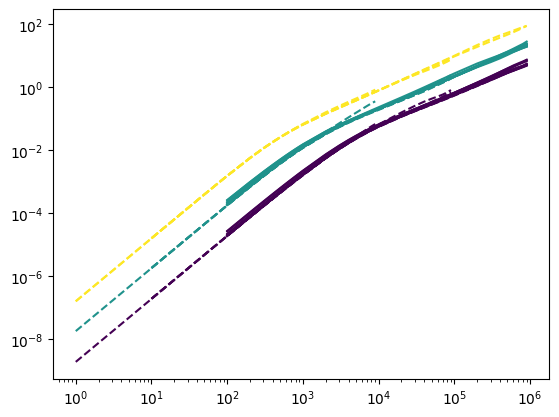

In [30]:
base = '/home/mmccraw/dev/data/09-27-25/test-scales'
# disk, rigid

root = os.path.join(base, 'disk')
is_rigid = 'rigid' in root
T = []
M = []
G = []
TIME = []
TE = []
PHI = []

for temperature in os.listdir(root):
    if os.path.isfile(os.path.join(root, temperature)):
        continue
    try:
        particle = load(os.path.join(root, temperature), location=['final', 'init'], load_trajectory=True, load_full=False)
    except:
        continue
    temp = np.array([particle.trajectory[i].temperature for i in range(particle.trajectory.num_frames())])
    area = np.prod(particle.box_size, axis=-1)
    ke = np.array([particle.trajectory[i].ke_total for i in range(particle.trajectory.num_frames())])
    pe = np.array([particle.trajectory[i].pe_total for i in range(particle.trajectory.num_frames())])
    te = ke + pe
    TE.append(np.std(te, axis=0) / np.mean(te, axis=0))
    if not hasattr(particle.init, 'packing_fraction'):
        particle.calculate_packing_fraction()
        PHI.append(particle.packing_fraction)
    else:
        PHI.append(particle.init.packing_fraction)

    path = os.path.join(root, temperature)
    msd_path = path + '_msd.npz'
    if os.path.exists(msd_path):
        msd = np.load(msd_path)['msd']
        t = np.load(msd_path)['t']
    else:
        if is_rigid:
            msd, t = compute_rotational_msd(particle, msd_path)
        else:
            msd, t = compute_msd(particle, msd_path)
    shear_modulus_path = path + '_shear_modulus.npz'
    if os.path.exists(shear_modulus_path):
        shear_modulus = np.load(shear_modulus_path)['shear_modulus']
        shear_modulus *= area / np.mean(temp, axis=0)
        t = np.load(shear_modulus_path)['t']
    else:
        shear_modulus, t = compute_shear_modulus(particle, shear_modulus_path)
        shear_modulus *= area / np.mean(temp, axis=0)
    G.append(shear_modulus)
    M.append(msd)
    T.append(np.mean(temp, axis=0))
    TIME.append(t)

norm = LogNorm(vmin=np.min(T), vmax=np.max(T))
cmap = plt.cm.viridis
for i in range(len(T)):
    for sid in range(M[i].shape[1]):
        plt.plot(TIME[i], M[i][:, sid], c=cmap(norm(T[i][sid])), linestyle='--')


root = os.path.join(base, 'rigid')
is_rigid = 'rigid' in root
T = []
M = []
G = []
TIME = []
TE = []
PHI = []
MU = []

for temperature in os.listdir(root):
    if os.path.isfile(os.path.join(root, temperature)):
        continue
    try:
        particle = load(os.path.join(root, temperature), location=['final', 'init'], load_trajectory=True, load_full=False)
    except:
        continue
    temp = np.array([particle.trajectory[i].temperature for i in range(particle.trajectory.num_frames())])
    area = np.prod(particle.box_size, axis=-1)
    ke = np.array([particle.trajectory[i].ke_total for i in range(particle.trajectory.num_frames())])
    pe = np.array([particle.trajectory[i].pe_total for i in range(particle.trajectory.num_frames())])
    te = ke + pe
    TE.append(np.std(te, axis=0) / np.mean(te, axis=0))
    if not hasattr(particle.init, 'packing_fraction'):
        particle.calculate_packing_fraction()
        PHI.append(particle.packing_fraction)
    else:
        PHI.append(particle.init.packing_fraction)

    if is_rigid:
        particle.calculate_mu_eff()
        MU.append(particle.mu_eff[particle.system_offset[:-1]])

    path = os.path.join(root, temperature)
    msd_path = path + '_msd.npz'
    if os.path.exists(msd_path):
        msd = np.load(msd_path)['msd']
        t = np.load(msd_path)['t']
    else:
        if is_rigid:
            msd, t = compute_rotational_msd(particle, msd_path)
        else:
            msd, t = compute_msd(particle, msd_path)
    shear_modulus_path = path + '_shear_modulus.npz'
    if os.path.exists(shear_modulus_path):
        shear_modulus = np.load(shear_modulus_path)['shear_modulus']
        shear_modulus *= area / np.mean(temp, axis=0)
        t = np.load(shear_modulus_path)['t']
    else:
        shear_modulus, t = compute_shear_modulus(particle, shear_modulus_path)
        shear_modulus *= area / np.mean(temp, axis=0)
    G.append(shear_modulus)
    M.append(msd)
    T.append(np.mean(temp, axis=0))
    TIME.append(t)


for i in range(len(T)):
    for sid in range(M[i].shape[1]):
        if M[i][:, sid].ndim == 2:
            mu = MU[i][sid]
            if mu > 5e-2:
                continue
            plt.plot(TIME[i], M[i][:, sid, 0], c=cmap(norm(T[i][sid])))

plt.xscale('log')
plt.yscale('log')
plt.show()

# Trying to speed up Rigid Bumpy case by selectively removing the core vertices when not needed


Hmm.  Doesn't seem to really do anything.

In [5]:
import tempfile
import subprocess
import time
from system_building_resources import *
radii = generate_bidisperse_radii(1000, 0.5, 1.4)
which = 'small'
packing_fraction = 0.7
temperature = 1e-5
n_steps = 1e6
save_freq = 1e2


mu_effs = []
nvs = []
for mu_eff in [0.01, 0.05, 0.1, 0.5, 1.0]:
    for nv in [3, 6, 10, 20, 30]:
        mu_effs.append(mu_eff)
        nvs.append(nv)
n_duplicates = len(mu_effs)
cap_nv = 3



add_core = 'selective'
rb = build_rigid_bumpy_system_from_radii(radii, which, mu_effs, nvs, packing_fraction, add_core, cap_nv, n_duplicates, draw_figures=True)
temp_dir = tempfile.mkdtemp()
rb.set_velocities(temperature, np.random.randint(0, 1e9))
# rb.set_neighbor_method(NeighborMethod.Naive)
rb.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(rb, 0.3)
rb.save(temp_dir)

start_time = time.time()
subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    temp_dir,
    temp_dir,
    str(1e5),
    str(1e5)
], check=True)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
shutil.rmtree(temp_dir)


add_core = True
rb = build_rigid_bumpy_system_from_radii(radii, which, mu_effs, nvs, packing_fraction, add_core, cap_nv, n_duplicates, draw_figures=True)
temp_dir = tempfile.mkdtemp()
rb.set_velocities(temperature, np.random.randint(0, 1e9))
# rb.set_neighbor_method(NeighborMethod.Naive)
rb.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(rb, 0.3)
rb.save(temp_dir)

start_time = time.time()
subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    temp_dir,
    temp_dir,
    str(1e5),
    str(1e5)
], check=True)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
shutil.rmtree(temp_dir)

Minimizing
Done
Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done
Time taken: 63.52896285057068 seconds
Minimizing
Done
Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done
Time taken: 67.06734418869019 seconds


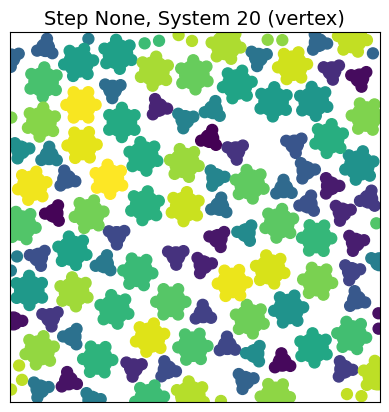

In [134]:
draw_particles_frame(None, plt.gca(), rb, 20, True, 'vertex', 'viridis', None)

Minimizing
Done


/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)
/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)


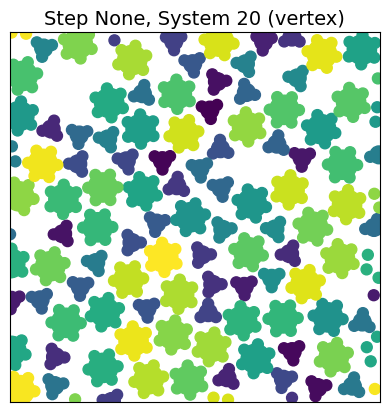

In [77]:
draw_particles_frame(None, plt.gca(), rb, 20, True, 'vertex', 'viridis', None)

In [121]:
desired_frames = 100
steps_to_animate = downsample(particle, desired_frames)

# Define the output path
output_path = "test.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=particle,
    system_id=20,
    use_pbc=True,
    which='particle',
    cmap_name='viridis'
)

Creating animation:   0%|          | 0/1 [00:00<?, ?it/s]

Saving animation to test.gif...


Creating animation: 2it [00:00,  5.35it/s]               

Animation saved successfully!
